# SciML HW Assignment 1

Given a 3D input-output dataset generated by solving the Navier-Stokes equations on a very coarse mesh, your assignment is to train and test _any model in any framework_ and to achieve the best compromise between training and testing accuracy. You will be graded on results and code quality, and, _most of all_, on your ability to explain in later discussions with us the modeling choices you made and how you arrived at them.

# Install
Please install all any needed packages here.

In [1]:
# Code goes here
%pip install numpy matplotlib google

# Import

Please import any needed packages here

In [2]:
# Code goes here
import matplotlib.pyplot as plt
import numpy as np

# Data
To get you started we define a dataset, `Assignemnt1`, as a python iteratable in the standard pytorch dataset style.

NOTE: data is loaded as numpy arrays for convenience. The axes in the loaded data are (U, x, y, z). The "extra" dimension in the inputs (3, 10, 11, 10) is for the boundary conditions on the top wall.

To upload the `.npz` data we provided in the zip file use the upload file button in files sidebar on Colab.

In [3]:
class Assignment1:
    """A very simple dataset iterator."""
    def __init__(self, path):
        data = np.load(path)
        self.inputs = data["inputs"]
        self.outputs = data["outputs"]
        self.meshgrids = data["grids"]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx], self.meshgrids[idx]

Load the data and show examples.

In [39]:
yaml_data = {
    "dataset": {
        "path": "/content/assignment_1_data.npz"
    },

    "FNO": {
      "modes": 8,
      "width": 50,
      "use_batch_norm": True,
    },

    "dlResNet": {
      "in_channels": 3,
      "out_channels_lst": [16, 32],
      "dilations": [1,2,4,2,1],
      "kernel_size": 1,
      "down_sample": False,
      "use_batch_norm": True
    },

    "training": {
      "batch_size": 18,
      "learning_rate": 0.001,
      "epochs": 100,
      "step_size": 50,
      "gamma": 0.05,
      "r": 8
    }
}

In [4]:
data_path = "/content/assignment_1_data.npz"  # NOTE: this is default colab upload path

dataset = Assignment1(data_path)

inputs_example, outputs_example, meshgrids_example = dataset[0]

print("len(dataset): ", len(dataset))
print("inputs_example.shape: ", inputs_example.shape)
print("outputs_example.shape: ", outputs_example.shape)
print("meshgrids_example.shape: ", meshgrids_example.shape)

len(dataset):  180
inputs_example.shape:  (3, 10, 11, 10)
outputs_example.shape:  (3, 10, 10, 10)
meshgrids_example.shape:  (3, 10, 10, 10)


Visualization examples (assumes numpy arrays; convert as needed)

In [5]:
def plot_slices(data, var=0, axis=2, interpolation='bilinear'):
    """Visualize a stack of images for Assignment 1.

    Parameters
    -----------
    data : array-like, 4d (U, x, y, z)
        The data to plot
    var : int
        The variable in U to plot, 0 -> Ux, 1 -> Uy, 2 -> Uz.
    axis: int
        The axis to slice down. The simulation is pseudo-3d meaning
        axis=2 gives the most physically realistic looking profiles.
        Focus on this axis in analyzing your model's results.
    interpolation: str, default: rcParams["image.interpolation"] (default: 'antialiased')
        The interpolation method used.
        Supported values are 'none', 'antialiased', 'nearest', 'bilinear', 'bicubic', 'spline16',
        'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian',
        'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'.
    """

    fig, ax = plt.subplots(2, 5, figsize=(7, 3.5), sharex="all")

    # Nice major title
    if var == 0:
        var_code = "$U_x$"
    if var == 1:
        var_code = "$U_y$"
    if var == 2:
        var_code = "$U_z$"
    plt.suptitle(var_code)

    # Plot slice + nice subtitle.
    for i in range(10):
        if axis == 0:
            ax.ravel()[i].imshow(data[var, i, :, :], interpolation=interpolation)
            ax.ravel()[i].set_title(f"$x={i}$")
        elif axis == 1:
            ax.ravel()[i].imshow(data[var, :, i, :], interpolation=interpolation)
            ax.ravel()[i].set_title(f"$y={i}$")
        elif axis == 2:
            ax.ravel()[i].imshow(data[var, :, :, i], interpolation=interpolation)
            ax.ravel()[i].set_title(f"$z={i}$")
        else:
            raise ValueError("slice_axis must be between [0, 2]")

        # No axis labels
        ax.ravel()[i].get_xaxis().set_visible(False)
        ax.ravel()[i].get_yaxis().set_visible(False)


Visualize input

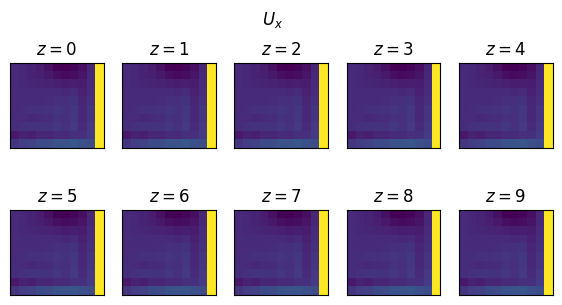

In [6]:
var = 0 # NOTE: 0 -> Ux, 1 -> Uy, 2 -> Uz
interpolation = None

plot_slices(inputs_example, var=var, interpolation=interpolation)

Visualize output (the target to predict)

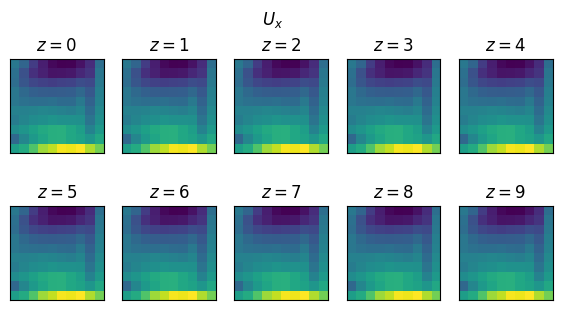

In [7]:
plot_slices(outputs_example, var=var, interpolation=interpolation)

Visualize input - output (dropping the boundary condition)

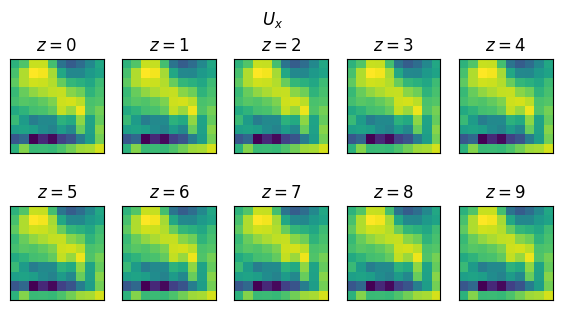

In [8]:
plot_slices(inputs_example[:, :, :-1, :] - outputs_example, var=var, interpolation=interpolation)

# Train and Model
Define your model(s), training code, and any preprocessing code in the cells below

In [12]:
# Model: 3D FNO
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)
np.random.seed(0)

## Model I: Fourier Neural Operator

In [13]:
class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d, self).__init__()

        """
        3D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul3d(self, input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return torch.einsum("bixyz,ioxyz->boxyz", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]

        # print(f"spectral conv, x shape = {x.shape}")

        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])

        # print(f"spectral convolution x_ft = {x_ft.shape}")

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))
        # print(f"spectral convolution x_ifft = {x.shape}")
        return x

class FNO3d(nn.Module):
    def __init__(self, modes1, modes2, modes3, width, use_bn=False):
        super(FNO3d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input shape: (batchsize, x=10, y=11, z=10, c=3)
        output shape: (batchsize, x=10, y=11, t=10, c=3)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        self.use_bn = use_bn
        self.padding = 6 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(6, self.width)
        # input channel is 6: the solution + 3 locations (u(x), u(y), u(z), x, y, z)

        self.conv0 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv1 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv2 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv3 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.w0 = nn.Conv3d(self.width, self.width, 1)
        self.w1 = nn.Conv3d(self.width, self.width, 1)
        self.w2 = nn.Conv3d(self.width, self.width, 1)
        self.w3 = nn.Conv3d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm3d(self.width)
        self.bn1 = torch.nn.BatchNorm3d(self.width)
        self.bn2 = torch.nn.BatchNorm3d(self.width)
        self.bn3 = torch.nn.BatchNorm3d(self.width)

        # handles the dimension of y
        self.w4 = torch.nn.Conv3d(self.width, self.width, kernel_size=(1,2,1))
        self.bn4 = torch.nn.BatchNorm3d(self.width)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 3)


    """
    interestingly, in their implementation, even though batchnorms are implemented, they were never used
    """
    def forward(self, x):

        grid = self.get_grid(x.shape, x.device)

        x = torch.cat((x, grid), dim=-1)

        x = self.fc0(x)
        x = x.permute(0, 4, 1, 2, 3)


        x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic
        # print(f"x pad = {x.shape}")

        x1 = self.conv0(x)
        x2 = self.w0(x)
        if self.use_bn:
            x2 = self.bn0(x2)
        x = x1 + x2
        x = F.gelu(x)

        # print(f"x conv0 = {x.shape}")

        x1 = self.conv1(x)
        x2 = self.w1(x)
        if self.use_bn:
            x2 = self.bn1(x2)
        x = x1 + x2
        x = F.gelu(x)

        # print(f"x conv1 = {x.shape}")

        x1 = self.conv2(x)
        x2 = self.w2(x)
        if self.use_bn:
            x2 = self.bn2(x)
        x = x1 + x2
        x = F.gelu(x)

        # print(f"x conv2 = {x.shape}")

        x1 = self.conv3(x)
        x2 = self.w3(x)
        if self.use_bn:
            x2 = self.bn2(x)
        x = x1 + x2

        # print(f"x conv3 = {x.shape}") # (18, 32, 10, 11, 10)

        # only spatial convolution to get the correct dimension
        x = self.w4(x)
        if self.use_bn:
            x = self.bn4(x)

        x = x[..., :-self.padding]
        # (18, 10, 10, 10, 32)
        x = x.permute(0, 2, 3, 4, 1) # pad the domain if input is non-periodic
        x = self.fc1(x)

        # print(f"x fc 1 = {x.shape}")

        x = F.gelu(x)
        x = self.fc2(x)
        # print(f"x fc2 = {x.shape}")
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y, size_z = shape[0], shape[1], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1, 1).repeat([batchsize, 1, size_y, size_z, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1, 1).repeat([batchsize, size_x, 1, size_z, 1])
        gridz = torch.tensor(np.linspace(0, 1, size_z), dtype=torch.float)
        gridz = gridz.reshape(1, 1, 1, size_z, 1).repeat([batchsize, size_x, size_y, 1, 1])
        return torch.cat((gridx, gridy, gridz), dim=-1).to(device)

## Model 2: DilatedResNet

In [34]:
import torch.nn as nn

"""
we only have a very coarse-grained grid of 10x10x10, therefore, instead of 7 dilated conv3d, we use [1,2,1] or [1,2,4,2,1]
kernel size for cnn either 1 or 2
"""

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None, dilations=[1,2,4,2,1], residual=True):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=in_channels, out_channels=out_channels, stride=stride, kernel_size=kernel_size,
                               padding=dilations[0], dilation=dilations[0])
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv3d(in_channels=out_channels, out_channels=out_channels, stride=stride, kernel_size=kernel_size,
                               padding=dilations[1], dilation=dilations[1])
        self.bn2 = nn.BatchNorm3d(out_channels)

        self.conv3 = nn.Conv3d(in_channels=out_channels, out_channels=out_channels, stride=stride, kernel_size=kernel_size,
                               padding=dilations[2], dilation=dilations[2])
        self.bn3 = nn.BatchNorm3d(out_channels)

        self.conv4 = nn.Conv3d(in_channels=out_channels, out_channels=out_channels, stride=stride, kernel_size=kernel_size,
                               padding=dilations[3], dilation=dilations[3])
        self.bn4 = nn.BatchNorm3d(out_channels)

        self.conv5 = nn.Conv3d(in_channels=out_channels, out_channels=in_channels, stride=stride, kernel_size=kernel_size,
                               padding=dilations[-1], dilation=dilations[-1])
        self.bn5 = nn.BatchNorm3d(in_channels)

        self.kernel_size = kernel_size
        self.stride = stride
        self.downsample = downsample
        self.residual = residual

    """
    input x: (batch_size, C_in, D, H, W)
    """
    def forward(self, x):
        residual = x
        # print(f"block1 x = {x.shape}")
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)

        out = self.conv4(out)
        out = self.bn4(out)
        out = self.relu(out)

        out = self.conv5(out)
        out = self.bn5(out)
        out = self.relu(out)

        if self.downsample is not None:
            residual = self.downsample(out)
        if self.residual:
            out = out + residual
        out = self.relu(out)
        return out


"""
Dilated Residual ConvNet
- key point is that downsample means we are doing dimension reduction when autoencoding
"""
class DRN(nn.Module):
    def __init__(self, in_channels, out_channels_lst=[16,16], kernel_size=1, down_sample=False, use_bn=False):
        super(DRN, self).__init__()
        self.in_channels = in_channels
        self.out_channels_lst = out_channels_lst
        self.down_sample = down_sample
        self.kernel_size = kernel_size
        self.use_bn = use_bn

        self.encoder_channel_dim = out_channels_lst[0]
        self.block1_dim = out_channels_lst[0] if not down_sample else out_channels_lst[0] // 2
        self.decoder_channel_dim = out_channels_lst[0]

        self.encoder = nn.Conv3d(in_channels=in_channels, out_channels=self.encoder_channel_dim, kernel_size=kernel_size, stride=1)
        self.bn_enc = nn.BatchNorm3d(self.encoder_channel_dim)

        self.avg_pool = nn.AvgPool3d(kernel_size=kernel_size, stride=2)

        self.block1 = BasicBlock(in_channels=self.block1_dim, out_channels=self.out_channels_lst[1])

        self.decoder = nn.Conv3d(in_channels=self.decoder_channel_dim, out_channels=3, kernel_size=(kernel_size, kernel_size+1, kernel_size), stride=1)
        self.bn_dec = nn.BatchNorm3d(in_channels)
        self.decoder2 = nn.ConvTranspose3d(in_channels=self.decoder_channel_dim, out_channels=3, kernel_size=(kernel_size, kernel_size+1, kernel_size), stride=2)

        self.relu = nn.ReLU()

    """
    expect input of shape (batch_size, C_in, D,H,W)
    in our case: (18, 6, 10, 11, 10)
    """
    def forward(self, x):
        x = x.permute(0, 4, 1, 2, 3)
        out = self.encoder(x)
        if self.use_bn:
            out = self.bn_enc(out)
        if self.down_sample:
            out = self.avg_pool(out)
            print(f"DRN downsample = {out.shape}")
        out = self.relu(out)
        out = self.block1(out)
        if self.down_sample:
            out = self.decoder2(out)
            print(f"DRN decoder ds = {out.shape}")
        else:
            out = self.decoder(out)
        if self.use_bn:
            out = self.bn_dec(out)
        out = self.relu(out)
        return out

## Utilities

In [19]:
from torch.utils.data import DataLoader, TensorDataset

def get_train_test_loaders(yaml_data):
    data = np.load(yaml_data["dataset"]["path"])
    data_inputs, data_outputs = data["inputs"], data["outputs"]
    n_samples = len(data_inputs)
    idx = torch.randperm(n_samples)
    train_size = int(n_samples * 0.8)
    train_indices = idx[:train_size]
    test_indices = idx[train_size:]

    # FNO expects the input to be (batch_size, x,y, z, c)
    data_inputs = torch.tensor(data_inputs).permute(0, 2, 3, 4, 1)
    data_outputs = torch.tensor(data_outputs).permute(0, 2, 3, 4, 1)
    x_train, x_test = data_inputs[train_indices], data_inputs[test_indices]
    y_train, y_test = data_outputs[train_indices], data_outputs[test_indices]

    print(f"x_train shape = {x_train.shape}, y_train shape = {y_train.shape}")
    print(f"x_test shape = {x_test.shape}, y_test shape = {y_test.shape}")

    train_loader = DataLoader(TensorDataset(x_train, y_train),
                                batch_size=yaml_data["training"]["batch_size"], shuffle=True, drop_last=True)
    test_loader = DataLoader(TensorDataset(x_test, y_test),
                                batch_size=yaml_data["training"]["batch_size"], shuffle=True, drop_last=True)
    return train_loader, test_loader


"""
visualize the ground truth output scalar field against the predicted one
"""
def visualize_predictions(pred, index, output, model_name, var=0, axis=2, interpolation="bilinear"):
    plot_slices(pred[index], model_name, type="prediction", var=var, axis=axis, interpolation=interpolation)
    plot_slices(output[index], model_name, type="output", var=var, axis=axis, interpolation=interpolation)

class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        # print(f"loss: x = {x.shape}, y = {y.shape}")

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)




def visualize_training_curves(tr_losses, te_losses, model_name):
    fig = plt.figure(figsize=(15,10))
    epochs = range(1, len(tr_losses) + 1)
    plt.plot(epochs, tr_losses, label="Training loss")
    plt.plot(epochs, te_losses, label="Test loss")
    plt.title(f"Training vs. Test loss for {model_name}")
    plt.xlabel("Epochs")
    plt.ylabel(r"$L^p$ Loss")
    plt.xticks(np.arange(1, len(tr_losses)+1, 10))
    plt.legend(loc="best")


def visualize_training_curves_40(tr_losses, te_losses, model_name):
    fig = plt.figure(figsize=(15,10))
    # this only plots evolution of training losses after 40 epochs
    epochs = range(41, len(tr_losses)+1)
    plt.plot(epochs, tr_losses[40:], label="Training loss")
    plt.plot(epochs, te_losses[40:], label="Test loss")
    plt.title(f"Training vs. Test loss for {model_name}")
    plt.xlabel("Epochs")
    plt.ylabel(r"$L^p$ Loss")
    plt.xticks(np.arange(41, len(tr_losses)+1, 5))
    plt.legend(loc="best")


## Training

In [40]:
from torch.optim import Adam
from tqdm import tqdm

def train_model(yaml_data, model):
    train_loader, test_loader = get_train_test_loaders(yaml_data)
    device = torch.device("cuda")
    learning_rate = yaml_data["training"]["learning_rate"]
    scheduler_step = yaml_data["training"]["step_size"]
    scheduler_gamma = yaml_data["training"]["gamma"]
    epochs = yaml_data["training"]["epochs"]
    batch_size = yaml_data["training"]["batch_size"]
    use_bn = yaml_data[model]["use_batch_norm"]

    model_name = model

    if model_name == "FNO":
        modes = yaml_data[model_name]["modes"]
        width = yaml_data[model_name]["width"]
        model = FNO3d(modes, modes, modes, width, use_bn).to(device)
        model_file_name = f"FNO3d_modes={modes}_width={width}.pt"

    else:
        in_channels = yaml_data[model_name]["in_channels"]
        out_channels_lst = yaml_data[model_name]["out_channels_lst"]
        kernel_size = yaml_data[model_name]["kernel_size"]
        model = DRN(in_channels=in_channels, out_channels_lst=out_channels_lst, kernel_size=kernel_size, use_bn=use_bn).to(device)
        model_file_name = f"dlResNet_in={in_channels}_out={out_channels_lst}_ker={kernel_size}.pt"

    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)
    myloss = LpLoss(size_average=False)


    train_losses = []
    test_losses = []
    for ep in tqdm(range(epochs)):
        model.train()
        train_losses_batch = []
        train_l2_step = 0
        for input, output in train_loader:
            input = input.to(device)
            output = output.to(device)
            pred = model(input)
            # print(f"minibatch: input = {input.shape}, pred = {pred.shape}, output={output.shape}")
            loss = myloss(pred.reshape(batch_size, -1), output.reshape(batch_size, -1))
            train_l2_step += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses_batch.append(loss.item())
        avg_train_loss = np.mean(np.array(train_losses_batch))
        train_losses.append(avg_train_loss)

        test_losses_batch = []
        with torch.no_grad():
            for input, output in test_loader:
                input = input.to(device)
                output = output.to(device)
                pred = model(input)
                loss = myloss(pred.reshape(batch_size, -1), output.reshape(batch_size, -1))
                test_losses_batch.append(loss.item())
        avg_test_loss = np.mean(np.array(test_losses_batch))
        test_losses.append(avg_test_loss)
        scheduler.step()
    visualize_training_curves(tr_losses=train_losses, te_losses=test_losses, model_name=model_name)
    visualize_training_curves_40(tr_losses=train_losses, te_losses=test_losses, model_name=model_name)
    print(min(test_losses))

    return model


x_train shape = torch.Size([144, 10, 11, 10, 3]), y_train shape = torch.Size([144, 10, 10, 10, 3])
x_test shape = torch.Size([36, 10, 11, 10, 3]), y_test shape = torch.Size([36, 10, 10, 10, 3])


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


11.817121028900146


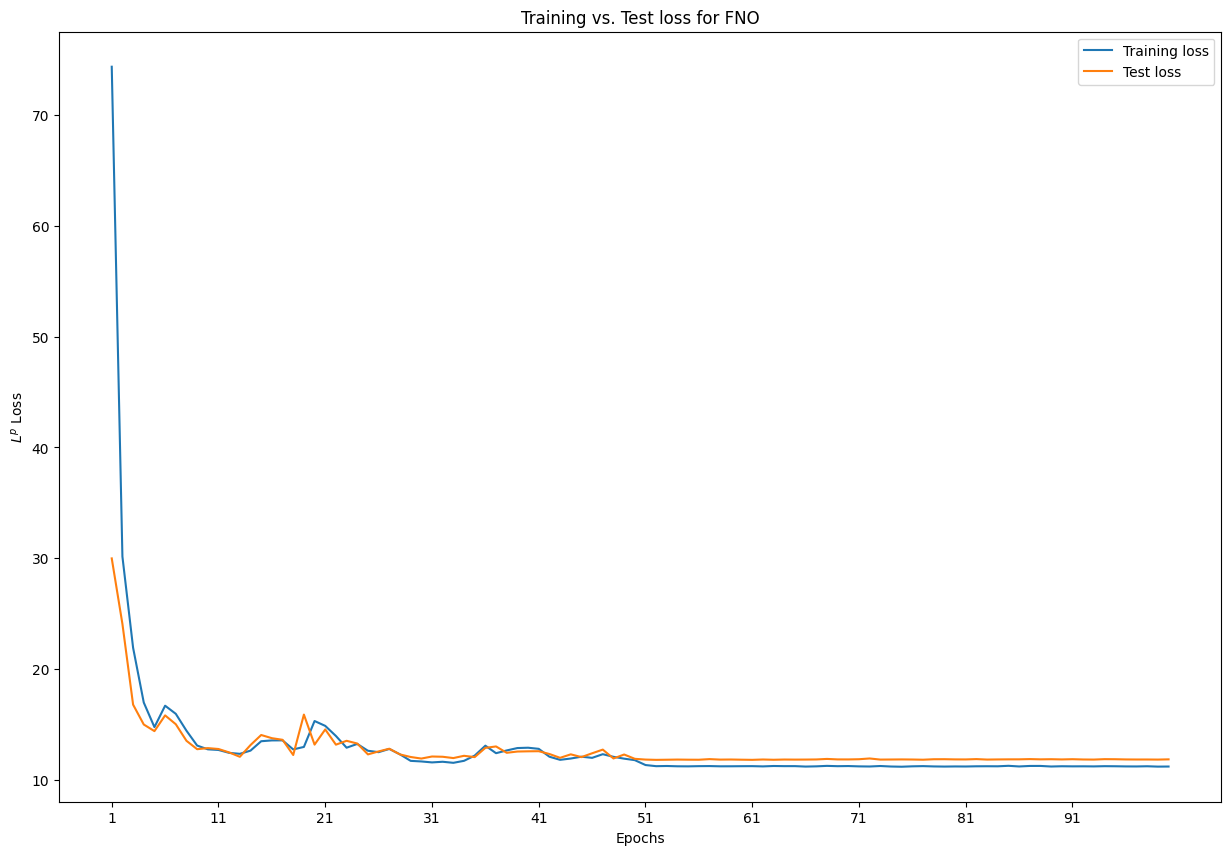

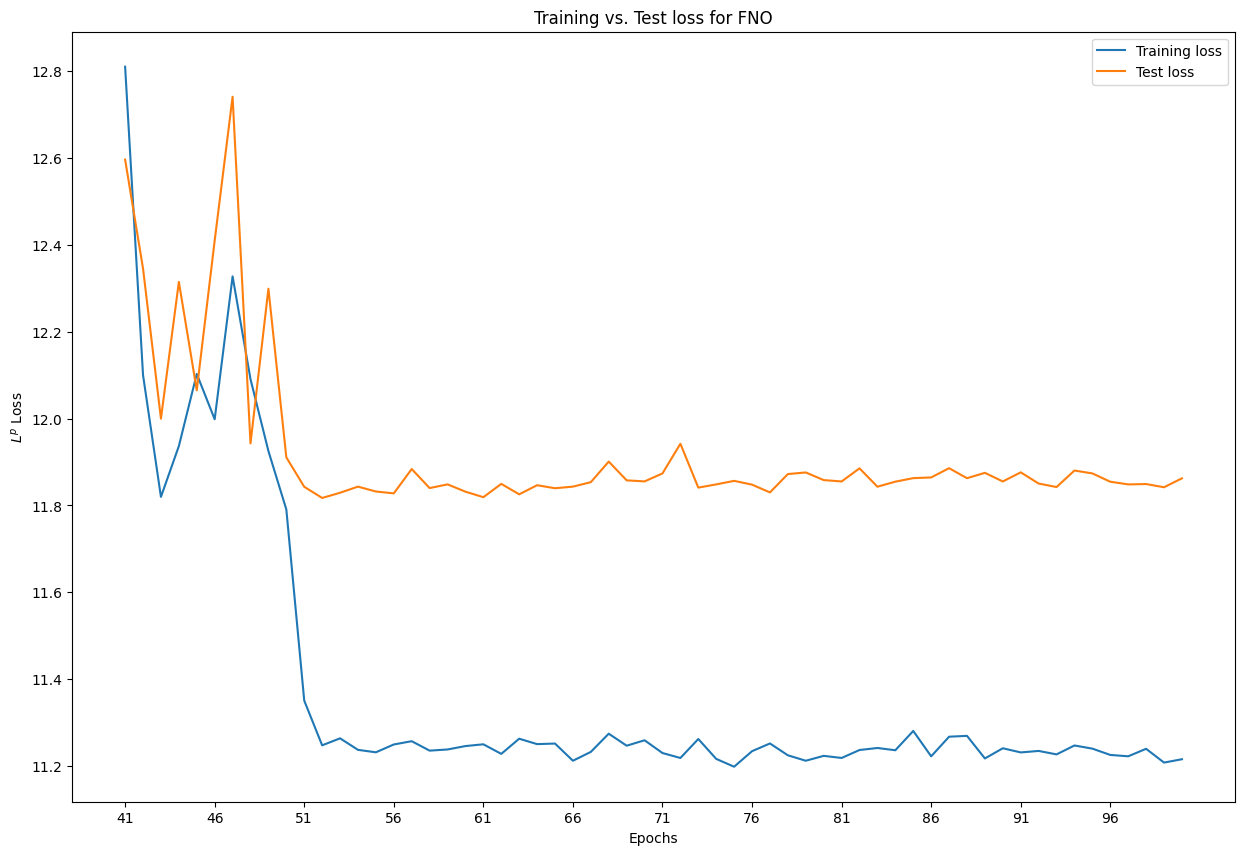

In [41]:
model_fno = train_model(yaml_data, "FNO")

x_train shape = torch.Size([144, 10, 11, 10, 3]), y_train shape = torch.Size([144, 10, 10, 10, 3])
x_test shape = torch.Size([36, 10, 11, 10, 3]), y_test shape = torch.Size([36, 10, 10, 10, 3])


100%|██████████| 100/100 [00:10<00:00,  9.45it/s]


17.486459732055664


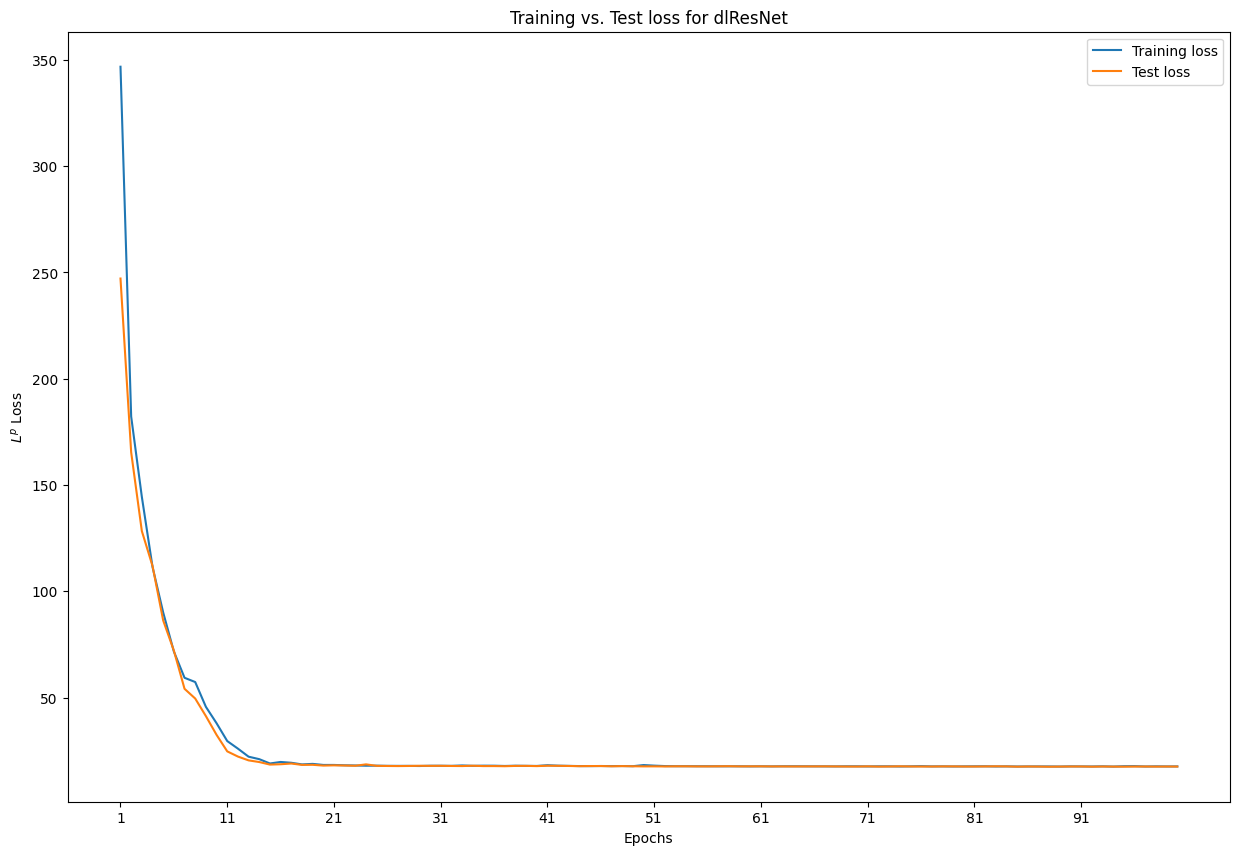

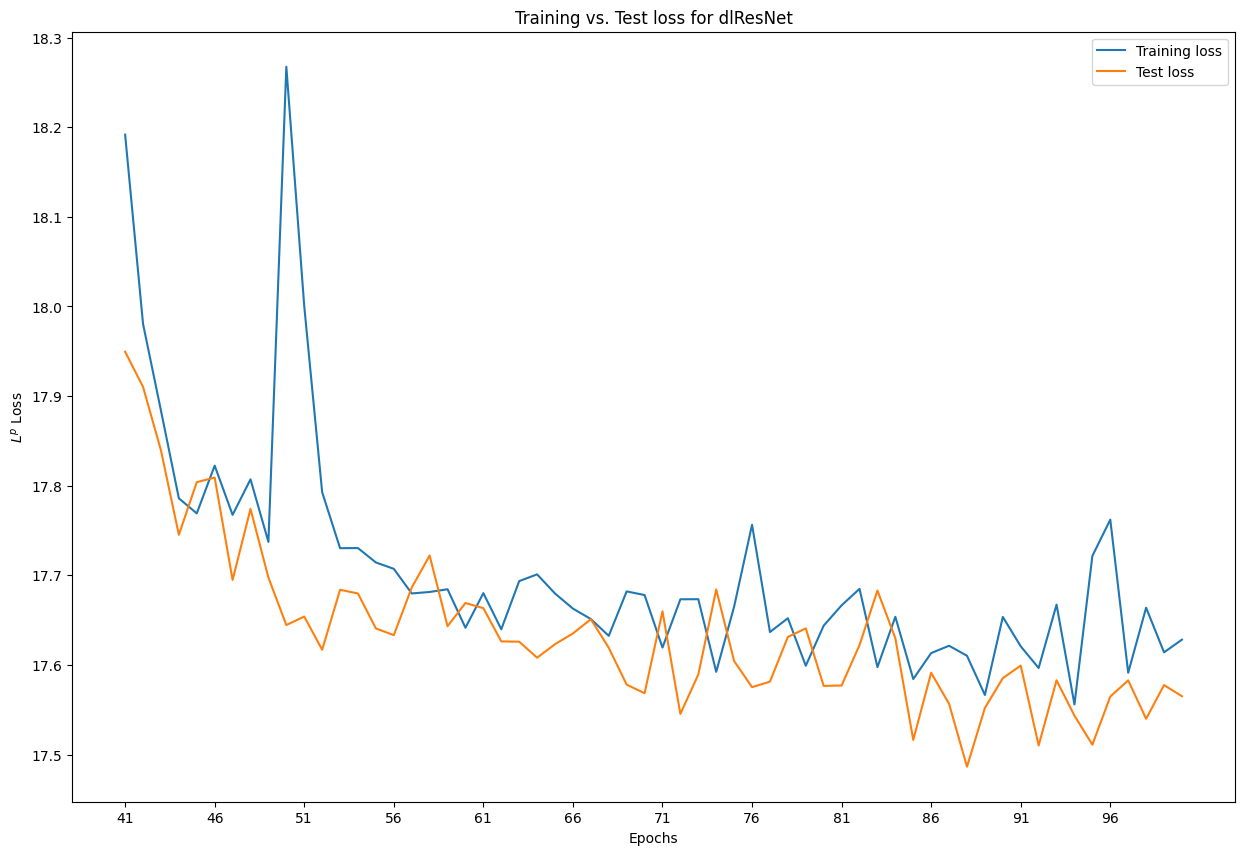

In [42]:
model_dlresnet = train_model(yaml_data, "dlResNet")

# Final results
Please print out the best results you were able to achieve in the cell below. We should be able to achieve similar results by simply rerunning all the cells in this notebook on Google Colab.

For the $L^p$ loss used by the Fourier Neural Operator, the best loss, as the average loss for a minibatch, is $11.8$ and is achieved by the FNO model.

In [43]:
device = torch.device("cuda")

In [51]:
def plot_slices(data, model_name, type, var=0, axis=2, interpolation='bilinear'):
    """Visualize a stack of images for Assignment 1.

    Parameters
    -----------
    data : array-like, 4d (U, x, y, z)
        The data to plot
    type: str
        pred or output data
    var : int
        The variable in U to plot, 0 -> Ux, 1 -> Uy, 2 -> Uz.
    axis: int
        The axis to slice down. The simulation is pseudo-3d meaning
        axis=2 gives the most physically realistic looking profiles.
        Focus on this axis in analyzing your model's results.
    interpolation: str, default: rcParams["image.interpolation"] (default: 'antialiased')
        The interpolation method used.
        Supported values are 'none', 'antialiased', 'nearest', 'bilinear', 'bicubic', 'spline16',
        'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian',
        'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'.
    """
    fig, ax = plt.subplots(2, 5, figsize=(7, 3.5), sharex="all")

    # Nice major title
    if var == 0:
        var_code = "$U_x$"
    if var == 1:
        var_code = "$U_y$"
    if var == 2:
        var_code = "$U_z$"
    title = f"{var_code} {model_name} {type}" if type == "pred" else f"{var_code} {type}"
    plt.suptitle(title)

    # Plot slice + nice subtitle.
    for i in range(10):
        if axis == 0:
            ax.ravel()[i].imshow(data[var, i, :, :], interpolation=interpolation)
            ax.ravel()[i].set_title(f"$x={i}$")
        elif axis == 1:
            ax.ravel()[i].imshow(data[var, :, i, :], interpolation=interpolation)
            ax.ravel()[i].set_title(f"$y={i}$")
        elif axis == 2:
            ax.ravel()[i].imshow(data[var, :, :, i], interpolation=interpolation)
            ax.ravel()[i].set_title(f"$z={i}$")
        else:
            raise ValueError("slice_axis must be between [0, 2]")

        # No axis labels
        ax.ravel()[i].get_xaxis().set_visible(False)
        ax.ravel()[i].get_yaxis().set_visible(False)

## Sample Prediction Visualization from FNO

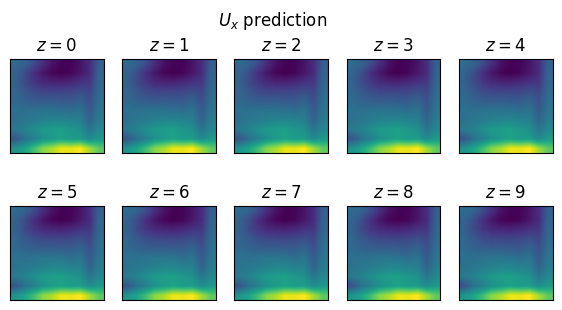

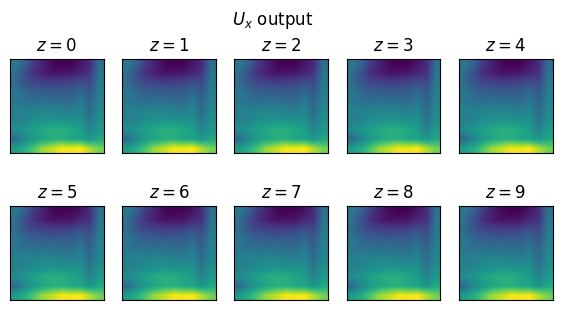

In [52]:
data = np.load(yaml_data["dataset"]["path"])
data_inputs = torch.tensor(data["inputs"]).permute(0,2,3,4,1).to(device)
data_outputs = data["outputs"]
preds = model_fno(data_inputs)
preds = preds.permute(0,4,1,2,3)
preds = preds.detach().cpu().numpy()
visualize_predictions(pred=preds, model_name="FNO", index=0, output=data_outputs)

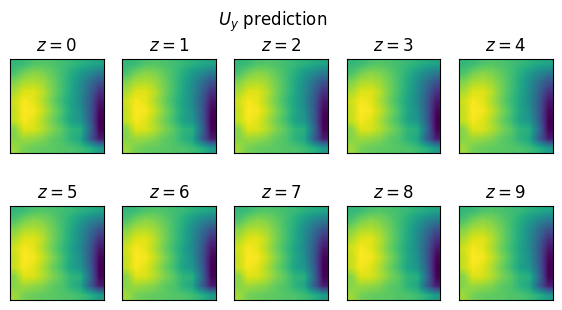

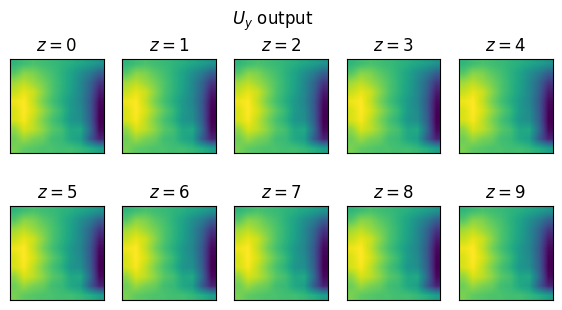

In [53]:
visualize_predictions(pred=preds, model_name="FNO", index=0, output=data_outputs, var=1)

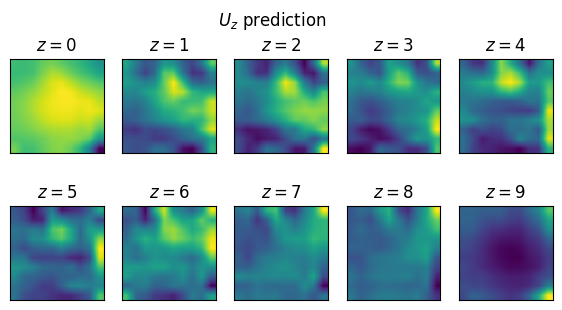

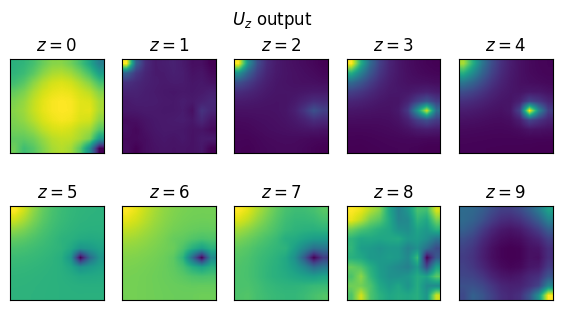

In [54]:
visualize_predictions(pred=preds, model_name="FNO", index=0, output=data_outputs, var=2)

## Sample Prediction Visualization for DlResNet

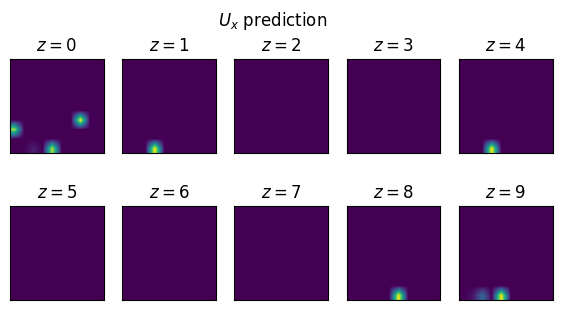

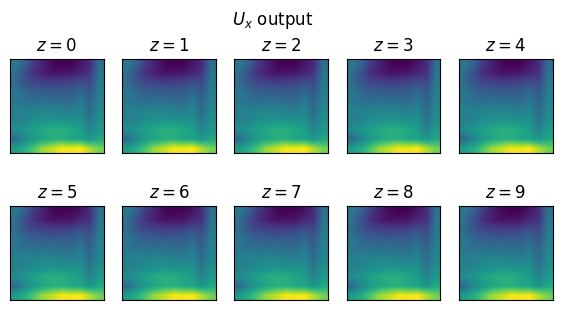

In [58]:
data = np.load(yaml_data["dataset"]["path"])
data_inputs = torch.tensor(data["inputs"]).permute(0,2,3,4,1).to(device)
data_outputs = data["outputs"]
preds = model_dlresnet(data_inputs)
preds = preds.detach().cpu().numpy()
visualize_predictions(pred=preds, model_name="DlResNet", index=0, output=data_outputs)

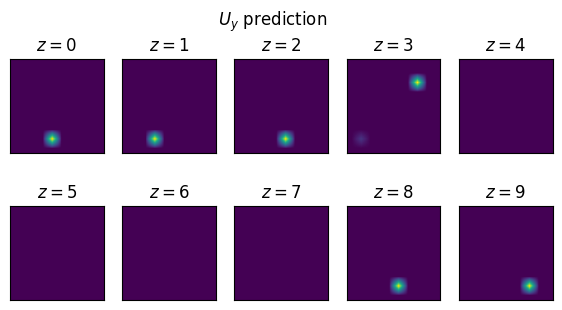

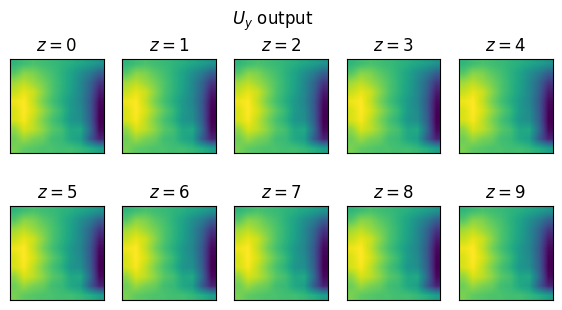

In [59]:
data = np.load(yaml_data["dataset"]["path"])
data_inputs = torch.tensor(data["inputs"]).permute(0,2,3,4,1).to(device)
data_outputs = data["outputs"]
preds = model_dlresnet(data_inputs)
preds = preds.detach().cpu().numpy()
visualize_predictions(pred=preds, model_name="DlResNet", index=0, output=data_outputs,var=1)

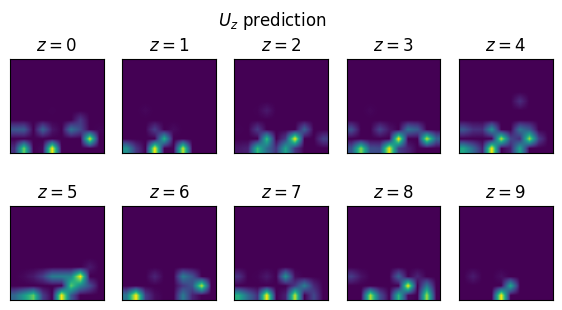

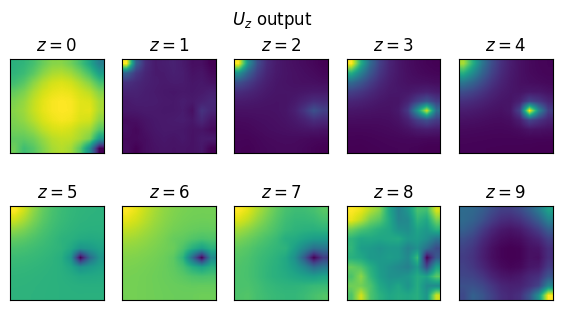

In [61]:
data = np.load(yaml_data["dataset"]["path"])
data_inputs = torch.tensor(data["inputs"]).permute(0,2,3,4,1).to(device)
data_outputs = data["outputs"]
preds = model_dlresnet(data_inputs)
preds = preds.detach().cpu().numpy()
visualize_predictions(pred=preds, model_name="DlResNet", index=0, output=data_outputs, var=2)